# Parsing

In [93]:
import math

def lmap(f,x):
    return list(map(f,x))

def loadCSV(path, x_id=0, y_id=1):
    with open(path) as inp:
        lines = inp.read().split("\n")[1:-2]
        rows = lmap(lambda l: lmap(float, l.strip().split(",")), lines)

        return {"x": lmap(lambda r: r[x_id], rows), "y": lmap(lambda r: r[y_id], rows)}

def process_raw_decay_data(id, startTime = -1, threshold = 0.7, col_id=2, SR=250, salt = "", floating_avg = True):
    peaks = []

    # startTime == -1 => auto cutoff
    auto_cutoff = False
    if(startTime == -1):
        auto_cutoff = True
        startTime = 0

    with open(f"./inputs/{id}.csv") as inp:
        lines = inp.read().split("\n")

        startInd = 1
        while (float(lines[startInd].split(",")[0]) < startTime): startInd += 1
        
        hitPeak = False
        startPeak = 0
        endPeak = 0
        for i in range(startInd, len(lines)-1):
            row = lines[i].split(",")

            # convert to true time

            if (float(row[col_id]) >= threshold and not hitPeak):
                hitPeak = True
                startPeak = float(row[0])/SR


            if (float(row[col_id]) < threshold and hitPeak):
                hitPeak = False
                endPeak = float(row[0])/SR

                peaks.append((endPeak+startPeak)/2)                

    

    results = {}
    interval = 1
    step = 0.1
    curTime = startTime
    x = 0
    while x < len(peaks):
        if (peaks[x] > curTime+interval):
            curTime += step
            x = 0
        elif (peaks[x] > curTime and peaks[x] < curTime+interval):
            if (not curTime in results): results[curTime] = 1
            else: results[curTime] += 1
            
        x += 1

    cutoff_val = math.inf
    if(auto_cutoff):
        cutoff_val = 0

    if(floating_avg):   
        with open(f"./outputs/{id}_{salt}_PROCESSED_FLOATING_AVERAGE.csv", 'w') as res:
            res.write("t, peaks/s, omega \n")
            for x in range(4, len(results.keys())):
                flAverage = 0
                for y in range(5):
                    flAverage += results[list(results.keys())[x-y]]
                flAverage = flAverage/5

                if(auto_cutoff):
                    if(flAverage > cutoff_val):
                        cutoff_val = flAverage

                if(flAverage < cutoff_val):
                    res.write(str(round(list(results.keys())[x-y], 1)) + "," + str(flAverage) + "," + str(flAverage*2*2*math.pi/16) + "\n")

        return f"./outputs/{id}_{salt}_PROCESSED_FLOATING_AVERAGE.csv"
    else:
        with open(f"./outputs/{id}_{salt}_PROCESSED.csv", 'w') as res:
            res.write("t, peaks/s \n")
            for key in results.keys():
                res.write(str(round(key, 1)) + "," + str(results[key]) + "\n")
        
        return f"./outputs/{id}_{salt}_PROCESSED.csv"


In [94]:
paths = [
    "1_to_1",
]
processed_paths = []
for p in paths:
    processed_paths.append(process_raw_decay_data(p, 0, -50, col_id=1, salt="CH1"))
    processed_paths.append(process_raw_decay_data(p, 0, -750, col_id=2, salt="CH2"))

# Processing

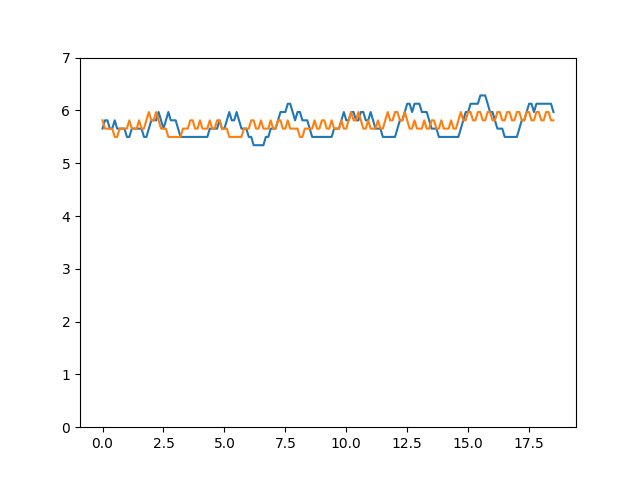

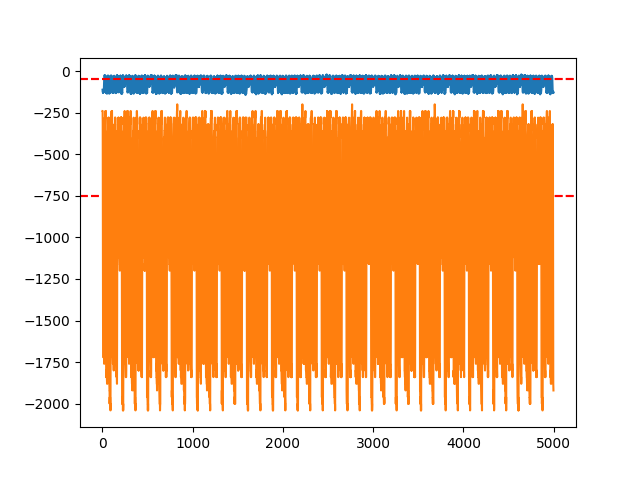

In [95]:
import math
import matplotlib.pyplot as plt
import matplotlib.lines as mpl_lines
import numpy as np

%matplotlib widget

for j in range(len(processed_paths)):
    path = processed_paths[j]
    
    data = loadCSV(path, 0, 2)

    plt.plot(data["x"], data["y"])
plt.ylim(0, 7)

# plt.figure()
# for j in range(len(processed_paths)):
#     path = processed_paths[j]
    
#     data = loadCSV("./inputs/" + paths[0] + ".csv", 0, j + 1)

#     plt.axhline(-50, 0, 5000, c="r", linestyle="--")
#     plt.axhline(-750, 0, 5000, c="r", linestyle="--")
#     plt.plot(data["x"], data["y"])